In [8]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

<h5> Packages used here: numpy, pandas, PIL(python imaging library) => to handle images

In [4]:
import pathlib

# downloading from the url
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

228813984/228813984 [==============================] - 11s 0us/step


In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'There are {image_count} images')

There are 3670 images


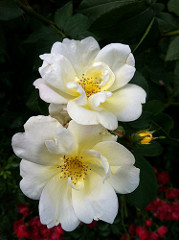

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))
# open image => then display

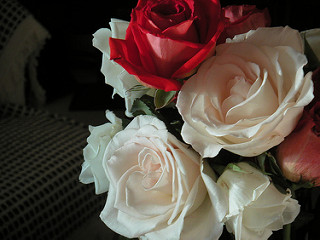

In [17]:
# get all the images of roses

roses = list(data_dir.glob('roses/*'))
im = PIL.Image.open(str(roses[1]))
im

In [18]:
batch_size = 32
img_height = 180
img_width = 180
# parameters for the loader each batch is of size 32 and the image should be of height=180, width=180
# currently, image size is 320x240

In [22]:
# getting the training dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

'''
In order to use this function, similar to text_dataset_from_directory

Directory must have no redundant folders aka folders not used for training
Format must be as follow
Class 1
  instance 1
  instance 2
  ...
Class 2
  instance 1
  instance 2
  ...
etc
'''

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


'\nIn order to use this function, similar to text_dataset_from_directory\n\nDirectory must have no redundant folders aka folders not used for training\nFormat must be as follow\nClass 1\n  instance 1\n  instance 2\n  ...\nClass 2\n  instance 1\n  instance 2\n  ...\netc\n'

In [23]:
# getting the validation dataset, using same seed to get the correct validation set

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [24]:
class_names = train_ds.class_names
print(f'The class names are {class_names}')

The class names are ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


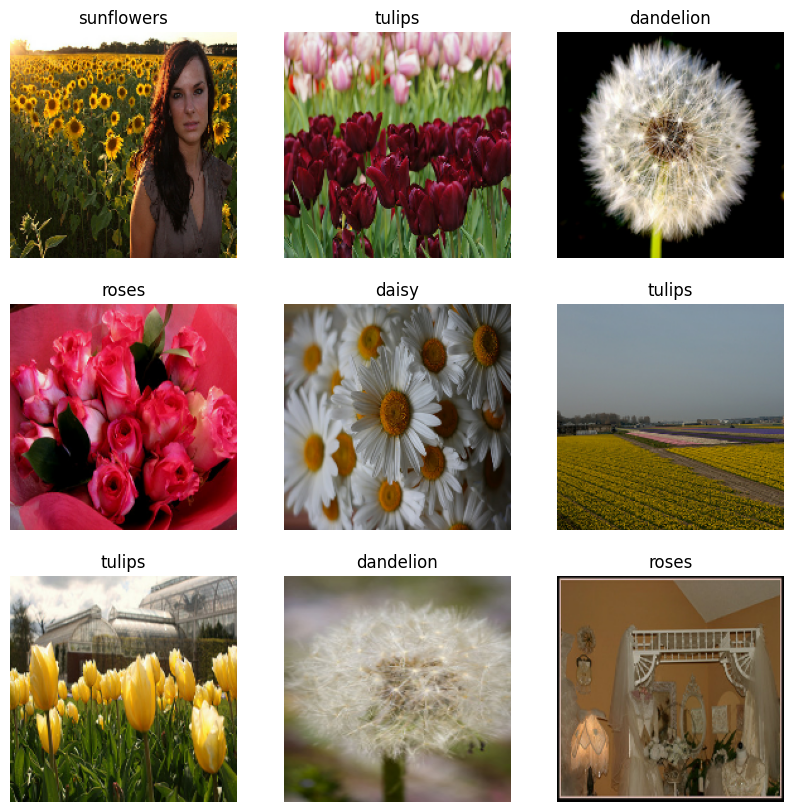

In [29]:
plt.figure(figsize=(10, 10))

'''
From the first batch, iterate through the first 9 images and plot them
'''
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # convert each image array to a numpy array, convert each pixel to an 8bit pixel, so that it will be a colour code
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [32]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

'''
In each batch, there are 32 images
Each image is 180x180 and has 3 channels: RGB

There are 32 labels which correspond to there being 32 images in each batch
'''

(32, 180, 180, 3)
(32,)


'\nIn each batch, there are 32 images\nEach image is 180x180 and has 3 channels: RGB\n\nThere are 32 labels which correspond to there being 32 images in each batch\n'

In [33]:
'''
In general, for Neural networks, should try to make the input values small => normalise them to be in the range 0-1, invariant of units (form of standardization)

How the scale feature works:
To map a domain from [0,255] to [0,1], use scale = 1./255
To map a domain from [0,255] to [-1,1], use scale = 1./127.5, offset=-1

Thus, value = domain_val/scale + offset
'''

normalization_layer = tf.keras.layers.Rescaling(scale=1./255)

<h5> Two ways to deploy normalization layer (if its first layer, its rescaling) <br>

1. Normalize the entire dataset before working with it <br>

2. Use it as one of the layers in the neural network

In [34]:
# map the function into the training data_set, each iteration in the train_ds will return a tuple of image and labels
# lambda x, y where x is the batch inputs and y is the label
# since we want to map the batch inputs and preserve the labels we return (normalization_layer(x), y)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.23730373 0.92265797


In [35]:
'''
Keeping the dataset in the RAM for fast access
'''

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
'''
Since we are doing an image classification task, we use a CNN
'''

num_classes = 5

model = tf.keras.Sequential([
    # input layer to rescale all the inputs
    tf.keras.layers.Rescaling(1./255),
    
    # First convolutional block
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    # Second convolutional block
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    # Third convolutional block
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    # Flatten the n dimensions into 1 dimension
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [46]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [47]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 37s 389ms/step - loss: 1.2779 - accuracy: 0.4554 - val_loss: 1.0528 - val_accuracy: 0.6008
Epoch 2/3
92/92 [==============================] - 36s 394ms/step - loss: 1.0095 - accuracy: 0.6029 - val_loss: 0.9511 - val_accuracy: 0.6499
Epoch 3/3
92/92 [==============================] - 37s 402ms/step - loss: 0.8648 - accuracy: 0.6693 - val_loss: 0.9046 - val_accuracy: 0.6621


In [48]:
'''
If no input shapes are given in the model, then the model will only be built during .fit

You can only see the summary after finishing the fitting process
'''

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 32)       